# Drake 系统基础

**学习目标：**
1. 从零实现一个自定义 `LeafSystem`
2. 理解 Drake 的模块图系统框架
3. 自己构建和连接模块图
4. 编写仿真代码
5. 高效使用 Drake 文档和教程

**你将实现的内容：** 你将从零实现一个倒立摆系统，并使用 Drake 内置的仿真工具对其进行仿真。

---


## 环境配置与导入

首先导入 Drake 的相关功能。我们会在后续逐步介绍这些内容，所以现在不用担心它们的细节。

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    BasicVector,
    ConstantVectorSource,
    Context,
    ContinuousState,
    Diagram,
    DiagramBuilder,
    LeafSystem,
    LogVectorOutput,
    Simulator,
)
from pydrake.systems.drawing import plot_system_graphviz

from manipulation.exercises.grader import Grader
from manipulation.exercises.intro.test_intro_fundamentals import (
    TestIntroFundamentalsPendulumImplementation,
    TestIntroFundamentalsSimulationExercises,
)

---

## 第一部分：编写你自己的动力学系统

Drake 通过**模块图（block diagram）**将复杂系统建模为由简单构件组成的系统。每个模块（`System`）：
- 拥有**输入端口**（接收信号）
- 拥有**输出端口**（发送信号）
- 维护内部**状态**
- 定义**动力学**（状态随时间的演化方式）

一个 `System` 可以是一个简单的单一系统，也可以是由多个更小的子系统组成的集合，例如通过 `Diagram` 连接在一起（我们很快会详细学习）。现在我们只关注单个自定义系统，通常你会通过继承 Drake 的 `LeafSystem` 类来实现。在本部分中，你将用 `LeafSystem` 实现一个简单的物理系统（倒立摆）。在后续课程和项目中，你可能会用 `LeafSystem` 实现自定义控制器、估计器、传感器等！

下图展示了一个由更小子系统组成的 `Diagram`：一个带有恒定输入源的倒立摆，其输出连接到日志记录系统。实际上，这就是我们将在本笔记本中从零搭建的 `Diagram`！

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/refs/heads/master/book/figures/simple_inverted_pendulum_diagram.svg" width="1000">

**参考资料：** 为了完成本笔记本中的任务，你将参考官方的 Drake 教程。现在不用全部阅读，我们在代码中会给出相关部分的提示。我们会用到的教程有：
- [动力学系统教程（Dynamical Systems Tutorial）](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)
- [自定义叶子系统（Authoring Leaf Systems）](https://github.com/RobotLocomotion/drake/blob/7abd7dc1a95387490e2d5fa23fe938f57eddecfc/tutorials/authoring_leaf_systems.ipynb)

如果你不确定某个函数的用法，可以查阅[官方 Drake 文档](https://drake.mit.edu/pydrake/index.html)。例如，`DeclareVectorInputPort` 及类似函数的文档可以在[此页面](https://drake.mit.edu/pydrake/pydrake.systems.framework.html)找到，我们是通过搜索 "DeclareVectorInputPort" 并用 cmd+F 定位到的。

（**关于 Drake 文档的说明：** Drake 有两套文档：一套是 Python 的，[另一套是 C++ 的](https://drake.mit.edu/doxygen_cxx/index.html)。C++ 和 Python 的 API 是一致的，但 C++ 文档通常更详细、更易于导航，所以大多数 Drake 用户更喜欢查阅 C++ 文档。随着你对 Drake 越来越熟悉，也可以多参考 C++ 文档！）

**你的任务：** 实现一个无摩擦的倒立摆作为自定义 `LeafSystem`
系统的具体参数如下：
- **状态：** $x = [\theta, \dot{\theta}]$（角度和角速度）
- **输入：** $u$（底座施加的力矩）
- **动力学：** $\ddot{\theta} = -\frac{g}{l}\sin(\theta) + \frac{u}{ml^2}$
- **输出：** $y = \theta$（仅输出角度）

In [22]:
# TODO：实现你自己的倒立摆类


class InvertedPendulum(LeafSystem):
    def __init__(
        self, mass: float = 1.0, length: float = 1.0, gravity: float = 9.81
    ) -> None:
        # 提示：参见动力学系统教程，
        #       “Deriving from LeafSystem”小节
        # TODO：调用父类构造函数
        super().__init__()
        # TODO：将物理参数保存为实例变量
        self.mass = mass
        self.length = length
        self.gravity = gravity
        # TODO：声明 [theta, theta_dot] 的连续状态
        #       （注意我们不需要像教程那样用 state_index，
        #        所以可以忽略返回值）
        self.DeclareContinuousState(2)  # 2 states: theta, theta_dot
        # 提示：参见自定义叶子系统教程，
        #       “Vector-valued Ports”小节
        # TODO：声明力矩输入端口
        self.input_port = self.DeclareVectorInputPort("torque", BasicVector(1))
        
        # TODO：将输入端口保存为实例变量，便于在 `DoCalcTimeDerivatives` 中访问
        self.torque_input_port = self.input_port # 保存输入端口
        # TODO：声明只输出 theta（不输出 theta_dot）的输出端口
        self.output_port = self.DeclareVectorOutputPort("theta", BasicVector(1), calc=self.OutputTheta) # 输出端口，只输出 theta

        # pass  # 实现后请移除此行

    def DoCalcTimeDerivatives(
        self, context: Context, derivatives: ContinuousState
    ) -> None:
        # 提示：参见动力学系统教程，
        #       “Deriving from LeafSystem”小节
        # TODO：从 context 获取当前状态（提取 theta 和 theta_dot）
        # 提示：context.get_continuous_state_vector() 返回 VectorBase 对象，
        #       可用索引方式获取 theta 和 theta_dot，
        #       如 .GetAtIndex() 或 context.get_continuous_state_vector()[index]
        theta = context.get_continuous_state_vector().GetAtIndex(0)  # theta
        theta_dot = context.get_continuous_state_vector().GetAtIndex(1)  # theta_dot
        # 提示：参见自定义叶子系统教程，
        #       “Vector-valued Ports”小节
        # TODO：通过评估输入端口获取输入力矩
        torque = self.torque_input_port.Eval(context)[0]  # 获取输入力矩

        # 提示：参见动力学系统教程，
        #       “Deriving from LeafSystem”小节
        # TODO：计算倒立摆动力学
        # TODO：设置导数 [theta_dot, theta_ddot]
        theta_ddot = -self.gravity / self.length * np.sin(theta) + torque / (self.mass * self.length ** 2) # theta_ddot = -g/l * sin(theta) + u/(m*l^2)
        derivatives.get_mutable_vector().SetAtIndex(0, theta_dot)  # d
        derivatives.get_mutable_vector().SetAtIndex(1, theta_ddot)  # dtheta_dot
        # pass  # 实现后请移除此行

    def OutputTheta(self, context: Context, output: BasicVector) -> None:
        # 提示：参见自定义叶子系统教程，
        #       “Vector-valued Ports”小节
        # TODO：从 context 获取状态，并提取 theta（第一个元素）
        theta = context.get_continuous_state_vector().GetAtIndex(0)
        # TODO：将输出端口设置为 theta
        output.SetAtIndex(0, theta)
        # pass  # 实现后请移除此行

**完成后，请务必运行下方的测试，确保一切如预期工作！**

In [23]:
Grader.grade_output(
    [TestIntroFundamentalsPendulumImplementation], [locals()], "results.json"
)
Grader.print_test_results("results.json")

Total score is 30/30.

Score for test_inverted_pendulum_structure (manipulation.exercises.intro.test_intro_fundamentals.TestIntroFundamentalsPendulumImplementation) is 10/10.

Score for test_pendulum_dynamics (manipulation.exercises.intro.test_intro_fundamentals.TestIntroFundamentalsPendulumImplementation) is 10/10.

Score for Test pendulum output computation is 10/10.


### 系统 `Context`
在上面的代码中，你可能注意到了 `context` 的用法。在 Drake 中，`context` 包含了你仿真和所有系统的全部动力学信息。

请在继续前阅读以下教程部分：
- [动力学系统教程](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)：**System "Context"** 部分

接下来，我们为我们的倒立摆创建一个默认 context，修改一下，并观察其内容！

对于这个简单系统，你会看到 context 只包含当前时间，以及我们为系统定义的两个状态。

In [24]:
# TODO: Set the values for time and state to some reasonable values
time = 0.0
theta = 0.1  
theta_dot = 0.0 

# TODO: Uncomment the following lines:
pendulum = InvertedPendulum()
pendulum_context = pendulum.CreateDefaultContext()
pendulum_context.get_mutable_continuous_state().SetFromVector([theta, theta_dot])
pendulum_context.SetTime(time)
print(pendulum_context)

::_ Context
------------
Time: 0
States:
  2 continuous states
    0.1   0




--- 
## 第二部分：在 Diagram 中连接系统

在本部分，你将通过连接多个 Drake `System`，创建一个完整的 `Diagram`，用于后续仿真：
1. **InvertedPendulum** —— 你的动力学系统
2. **ConstantVectorSource** —— 提供恒定力矩输入
3. **LogVectorOutput** —— 记录输出数据

**你的任务：** 构建一个用于倒立摆仿真的 `Diagram`，其中摆杆由恒定输入力矩驱动，并记录输出。

**参考资料：** 本部分只需参考以下教程（我们会在代码中持续给出相关部分的提示）：
- [动力学系统教程](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)：**Simulation** 和 **Combinations of Systems: Diagram and DiagramBuilder** 部分

In [25]:
# TODO：实现模块图构建函数


def build_pendulum_diagram(
    input_torque: float = 0.0,
) -> tuple[Diagram, InvertedPendulum, LogVectorOutput]:

    # 提示：参见动力学系统教程，“Simulation”小节
    # TODO：创建 DiagramBuilder
    builder = DiagramBuilder()
    # TODO：将你的倒立摆系统添加到 builder
    pendulum = builder.AddSystem(InvertedPendulum())
    # TODO：添加恒定力矩源
    # 提示：这部分教程中没有，代码已为你提供。
    torque_source = ConstantVectorSource(np.array([input_torque])) # 恒定力矩源

    # TODO：添加数据记录系统
    logger = LogVectorOutput(pendulum.get_output_port(0), builder)
    # TODO：连接各系统
    # 提示：参见动力学系统教程，
    #       “Combinations of Systems: Diagram and DiagramBuilder”小节
    # 提示：恒定力矩源应连接到倒立摆的输入端口，
    #       LogVectorOutput 已连接到倒立摆的输出端口。
    torque_source = builder.AddSystem(torque_source) 
    builder.Connect(torque_source.get_output_port(0), pendulum.get_input_port(0))  # 连接恒定力矩源到倒立摆输入端口


    # TODO：构建并返回最终的 diagram、系统和 logger
    diagram = builder.Build()
    return diagram, pendulum, logger


# TODO：取消注释下方代码：
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)

**接下来，我们将可视化这个模块图。**

Drake 可以自动生成你的模块图的图形化表示，这对于理解系统连接和调试连线问题非常有帮助。

运行下方代码可视化你的模块图：

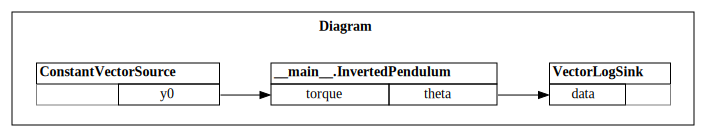

In [26]:
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)
plot_system_graphviz(diagram)

可视化后，请务必观察模块图。连接关系和端口数量是否如你预期？

我们也来看看 Diagram 的 context（注意它包含了之前的 pendulum context！）：

In [27]:
# TODO: Uncomment the following line:
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)

# TODO: Create a context for the diagram
context = diagram.CreateDefaultContext()

# TODO: Print the context for the diagram
print(context)

::_ Context (of a Diagram)
---------------------------
2 total continuous states
1 total numeric parameters in 1 groups

::_::__main__.InvertedPendulum@000055a2d556f2c0 Context
--------------------------------------------------------
Time: 0
States:
  2 continuous states
    0 0


::_::drake/systems/ConstantVectorSource@000055a2d5579430 Context
-----------------------------------------------------------------
Time: 0
Parameters:
  1 numeric parameter groups with
     1 parameters
       0.1



**小贴士：** 这在教程中没有提到，但在后续课程和项目中会**非常**有用：

如果你想从整个 diagram context 中获取某个具体系统的 context，可以用如下方法：

`system.GetMyContextFromRoot(diagram_context)`。

在下方尝试对倒立摆使用它，注意我们得到了之前打印的简单 pendulum context！


In [28]:
# TODO: Get the context of the pendulum from the diagram context
pendulum_context = diagram.GetSubsystemContext(pendulum, context)
# TODO: Print the pendulum context
print(pendulum_context)

::_::__main__.InvertedPendulum@000055a2d556f2c0 Context
--------------------------------------------------------
Time: 0
States:
  2 continuous states
    0 0




## 第三部分：仿真

在本部分，我们将把所有内容整合起来，运行倒立摆系统的完整仿真。

**你的任务：** 实现倒立摆系统的完整仿真。

**参考资料：** 本部分只需参考以下教程（我们会在代码中持续给出相关部分的提示）：
- [动力学系统教程](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)：**Simulation** 部分

In [29]:
# TODO：实现仿真函数


def simulate_pendulum(
    initial_state: np.ndarray, simulation_time: float = 5.0, torque: float = 0.0
) -> tuple[np.ndarray, np.ndarray]:
    # TODO：用你实现的函数构建模块图\
    diagram, pendulum, logger = build_pendulum_diagram(input_torque=torque)
    # 提示：参见动力学系统教程，“Simulation”小节
    # TODO：为 diagram 创建 context
    context = diagram.CreateDefaultContext()

    # TODO：用 context 创建仿真器
    simulator = Simulator(diagram, context)

    # TODO：为倒立摆设置初始条件
    pendulum_context = diagram.GetSubsystemContext(pendulum, context)
    pendulum_context.get_mutable_continuous_state().SetFromVector(initial_state)
    # TODO：运行仿真到指定时间
    simulator.AdvanceTo(simulation_time)

    # TODO：从 logger 提取记录数据
    log = logger.FindLog(context)
    time_data = log.sample_times()
    state_data = log.data()
    
    # TODO：返回日志中的时间和状态数据
    return time_data, state_data

完成后，运行下方代码测试你的实现。我们会检查摆杆是否摆过竖直向下的平衡点，并进行可视化，让你直观感受仿真效果！

Simulation complete! Recorded 407 timesteps
Initial angle: 0.5000 rad (28.6°)
Final angle: 0.4177 rad (23.9°)
✅ Physics check PASSED - pendulum oscillated as expected
Let us plot the angle over time (notice how there is no friction, hence the pendulum swings indefinitely!):


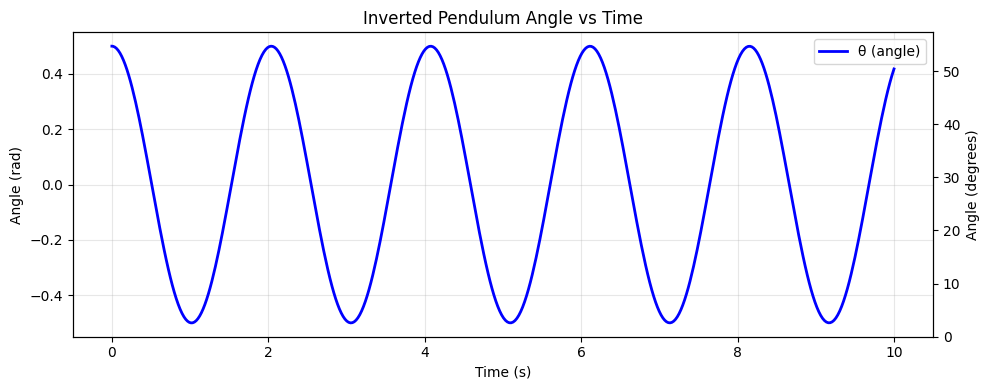

In [30]:
# Test your implementation (you do not need to modify this code)
initial_state = [0.5, 0.0]  # small angle, zero velocity
times, outputs = simulate_pendulum(initial_state, simulation_time=10.0, torque=0.0)

print(f"Simulation complete! Recorded {len(times)} timesteps")
print(f"Initial angle: {outputs[0, 0]:.4f} rad ({np.degrees(outputs[0, 0]):.1f}°)")
print(f"Final angle: {outputs[0, -1]:.4f} rad ({np.degrees(outputs[0, -1]):.1f}°)")

# Check if pendulum swung past the equilibrium point
min_angle = np.min(np.abs(outputs[0, :]))
if np.isclose(min_angle, 0.0, atol=1e-3):
    print("✅ Physics check PASSED - pendulum oscillated as expected")
else:
    print("❌ Physics check FAILED - pendulum didn't swing properly")

print(
    "Let us plot the angle over time (notice how there is no friction, hence the pendulum swings indefinitely!):"
)
# Plot the angle over time
plt.figure(figsize=(10, 4))
plt.plot(times, outputs[0, :], "b-", linewidth=2, label="θ (angle)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Inverted Pendulum Angle vs Time")
plt.grid(True, alpha=0.3)
plt.legend()

# Add degree labels on right y-axis
ax2 = plt.gca().twinx()
ax2.set_ylabel("Angle (degrees)")
ax2.set_ylim(np.degrees(plt.gca().get_ylim()[0]), np.degrees(plt.gca().get_ylim()[1]))

plt.tight_layout()
plt.show()

---

# GRADESCOPE 验证

**前提：** 你必须完成上方所有 TODO，以下验证练习才能正常运行！

**说明：** 完成下方练习。将你的验证 key（保留 4 位小数的数值）复制粘贴到 Gradescope。



## 验证 1：基础仿真

**任务：** 用如下参数仿真倒立摆：
- 初始状态：θ = 0.15 rad, θ̇ = 0.0 rad/s
- 无外加力矩（torque = 0.0）
- 仿真时间：2.5 秒

**问题：** t = 2.5 秒时，θ 的数值是多少？（保留 4 位小数）


In [31]:
# TODO：实现仿真练习

theta = 0.15
dot_theta = 0.0
torque = 0.0
sim_time = 2.5

time, state = simulate_pendulum([theta, dot_theta], simulation_time=sim_time, torque=torque)
print(f"Simulated {len(time)} steps over {sim_time} seconds")
print(f"Final angle: {state[0, -1]:.4f} rad ({np.degrees(state[0, -1]):.1f}°)")

Simulated 76 steps over 2.5 seconds
Final angle: 0.0052 rad (0.3°)


## 验证 2：有外加力矩

**任务：** 用如下参数仿真倒立摆：
- 初始状态：θ = -0.1 rad, θ̇ = 0.2 rad/s
- 恒定外加力矩：0.5 N⋅m
- 仿真时间：1.8 秒

**问题：** t = 1.8 秒时，θ 的数值是多少？（保留 4 位小数）


In [33]:
# TODO：实现仿真练习
theta = -0.1
dot_theta = 0.2
torque = 0.5
sim_time = 1.8

time, state = simulate_pendulum([theta, dot_theta], simulation_time=sim_time, torque=torque)
print(f"Simulated {len(time)} steps over {sim_time} seconds")
print(f"Final angle: {state[0, -1]:.4f} rad ({np.degrees(state[0, -1]):.1f}°)")

Simulated 56 steps over 1.8 seconds
Final angle: -0.1074 rad (-6.2°)


---

# 恭喜你！

你已成功完成 **Drake 系统基础**！你学到了：

1. **LeafSystem** 是大多数自定义 Drake 系统的基类
2. **Context** 保存了仿真的状态、时间和参数
3. **DiagramBuilder** 用于将系统连接成更大的组合体（`Diagram`）
4. **Drake 文档**和**Drake 教程**是你最好的朋友——多加利用！

**下一步：** 在 Notebook 2 中，你将用 `MultibodyPlant` 操作真实机器人，并创建自己的自定义资产！
